In [1]:
# Core imports
import heyoka as hk
import pykep as pk
import numpy as np
from numpy import linalg as la
import pandas as pd
import math
from numpy.lib.function_base import append
# Sys imports
import time
# Plot imports
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.ticker as mtick
# Other imports
from UROP_aux_func import *

In [2]:
"""
Constant parameters 
"""

GMe = 398601   #[km^3/sec^2]
Re  = 6371.22  #[km]
J2 = 0.00108265         # [-] second zonal harmonic
GMl = 4902.66 #[km^3/sec^2] for the Moon
rl = 384400   #[km] radius of the lunar orbit
omega_l = 2.665315780887e-6 #[1/s] lunar orbital angular velocity

In [3]:
#create heyoka variables
X,Y,Z = hk.make_vars("X","Y","Z")
VX,VY,VZ = hk.make_vars("VX","VY","VZ")

In [4]:
# Step 1: Define Initial Conditions (dimensional)
r0 = np.array([337.7834, -3109.3490, -6101.4423]) #km   (class 'numpy.ndarray')
v0 = np.array([10.00457,   1.086844,    0])       #km/s
[a0, e0_norm, i0, RAAN0, omega0, theta0] = rv2elorb(r0, v0, GMe)

In [5]:
# Step 2: non-dimensionalise the ICs
r0nd = r0 / a0 #[km/km] = [-] since the orbit is highly elliptical normalise with the initial semimajor axis
               # otherwise use r0nd = r0/la.norm(r0)
v0nd = v0 * math.sqrt(a0/GMe)    #[-]
t0   = 0                         #s
t0nd = t0 / math.sqrt((a0**3)/GMe) #[-]
# Non-dimensional ICs
S0 = [*r0nd, *v0nd]
# print(S0)

In [6]:
# Non-dimensionalise the parameters
GMend = 1 # GMe * a0d / (a0d * GMe) 
Rend  = Re / a0
rlnd  = rl / a0
omega_lnd = omega_l * math.sqrt((a0**3)/GMe)
GMlnd = GMl / GMe

In [7]:
# Final time
# Test - based on 100 orbits
T = 2*np.pi * np.sqrt(a0**3/GMe)  # orbital period
# print(f'the orbital period is {T/(24*3600)} days for one orbit')
n_orb = 1000
tf = T * n_orb
print(tf/(24*3600))

tfnd  = tf / math.sqrt((a0**3)/GMe)          #[-]  
m = 500
N = n_orb * m

print(N)
t_span = np.linspace(t0nd, tfnd, N, endpoint = True)
print(np.shape(t_span))

499.00426437843566
500000
(500000,)


In [8]:
#Earth's Keplerian terms
magR2 = X**2 + Y**2 + Z**2
r_norm = (magR2)**(1/2)
fKepX = -X/(magR2**(3./2))
fKepY = -Y/(magR2**(3./2))
fKepZ = -Z/(magR2**(3./2))

#Earth's J2 terms
fJ2X = ( (3/2)*J2*Rend**2/r_norm**4 ) * (X/r_norm)*(5*(Z**2/r_norm**2) -1)
fJ2Y = ( (3/2)*J2*Rend**2/r_norm**4 ) * (Y/r_norm)*(5*(Z**2/r_norm**2) -1)
fJ2Z = ( (3/2)*J2*Rend**2/r_norm**4 ) * (Z/r_norm)*(5*(Z**2/r_norm**2) -3)

# Third body (moon)
r3 = np.array([ rlnd * hk.sin(omega_lnd*hk.time),
                rlnd * (- (math.sqrt(3)*hk.cos(omega_lnd*hk.time))/2) ,
                rlnd * (- hk.cos(omega_lnd*hk.time)/2)])
r3_norm  = (r3[0]**2 + r3[1]**2 + r3[2]**2)**(1/2)
r3r      = r3 - np.array([X, Y, Z])
r3r_norm = (r3r[0]**2 + r3r[1]**2 + r3r[2]**2)**(1/2)

fLX = GMlnd * ( (r3[0] - X)/(r3r_norm**3) - r3[0]/(r3_norm**3) )
fLY = GMlnd * ( (r3[1] - Y)/(r3r_norm**3) - r3[1]/(r3_norm**3) )
fLZ = GMlnd * ( (r3[2] - Z)/(r3r_norm**3) - r3[2]/(r3_norm**3) )


In [9]:
#EOMs
dXdt = VX
dYdt = VY
dZdt = VZ
dVXdt = fKepX + fJ2X + fLX 
dVYdt = fKepY + fJ2Y + fLY 
dVZdt = fKepZ + fJ2Z + fLZ

In [19]:
ic = S0
print('Compiling the Taylor integrator ... (this is done only once)')
start_time = time.time()
ta = hk.taylor_adaptive(sys = [(X,dXdt),(Y,dYdt),(Z,dZdt),(VX,dVXdt),(VY,dVYdt),(VZ,dVZdt)],
                        state = ic,
                        time = t0nd,
                        tol = 1e-12,
                        compact_mode = True)#,  high_accuracy=True)
#end_time = time.time()

#print('Done, in');
#print("--- %s seconds ---" % (end_time - start_time))

print("\nHeyoka Taylor integrator:\n", ta)


Compiling the Taylor integrator ... (this is done only once)

Heyoka Taylor integrator:
 Taylor order            : 15
Dimension               : 6
Time                    : 0.0000000000000000
State                   : [0.012710620554896157, -0.11700324915832398, -0.22959422491718920, 2.5832415036124878, 0.28062980505431129, 0.0000000000000000]



In [20]:
# Here we redefine the initial conditions since we may want to change them without recompiling the integrator
ta.time = t0
# Note the python syntax to assign directly the array elements. Here necessary
# as heyoka does not allow to change the memory location of the state
ta.state[:] =  S0

In [21]:
#start_time = time.time()
out = ta.propagate_grid(t_span)
end_time = time.time()
#print(out)
print('Done, in');
print("--- %s seconds ---" % (end_time - start_time))
St = out[4] 
size = np.shape(St)
print(f'the shape of the solution (cartesian form) is {size}') # 431 138

Done, in
--- 1.2505362033843994 seconds ---
the shape of the solution (cartesian form) is (500000, 6)


In [24]:
rnd = St[:, :3]
vnd = St[:, -3:]
dim1, dim2 = np.shape(St)
print(dim1, dim2)

500000 6


In [25]:
# Dimensionalise the output state
r = np.empty((dim1, 3))
v = np.empty((dim1, 3))
for row in range(dim1):
    r[row, :] = rnd[row, :] * a0
    v[row, :] = vnd[row, :] / math.sqrt(a0/GMe)
#print(r[-1], v[-1])

r_norm = np.empty((1, dim1))
v_norm = np.empty((1, dim1))

for col in range(dim1):
    r_norm[0, col] = math.sqrt(r[col, 0]**2 + r[col, 1]**2 + r[col, 2]**2 )
    v_norm[0, col] = math.sqrt(v[col, 0]**2 + v[col, 1]**2 + v[col, 2]**2 )
    
#print(r_norm[0, -1], v_norm[0, -1])
#14739.174102904324,  15757.94708230248, 31551.285565525814, dromo16
# -1.0362193213928914, 1.02808010845871, 1.9496356150464975

# [14739.17409319 15757.94709116 31551.28558203] [-1.03621932  1.02808011  1.94963561] cowell16

r_ca = 46275.7204382744
v_ca = 1.517449320488149

print("abs error r: ", np.abs(r_norm[0, -1]-r_ca)*1000)
print("abs error v: ", np.abs(v_norm[0, -1]-v_ca)*1000)

abs error r:  0.7222489803098142
abs error v:  8.7794390646323e-05


In [68]:
t_days = np.empty((dim1, 1))
for t, i in zip(t_span, range(dim1)):
    t_days[i, 0] = ( t*math.sqrt((a0**3)/GMe) )/(24*3600)
    
print(t_days[-1]) 

[49.90042644]


            x            y            z
0  337.783400 -3109.349000 -6101.442300
1  437.806870 -3098.289254 -6101.065540
2  537.776431 -3086.848000 -6099.935408
3  637.679802 -3075.026802 -6098.052353
4  737.504738 -3062.827372 -6095.417121


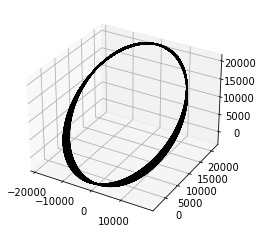

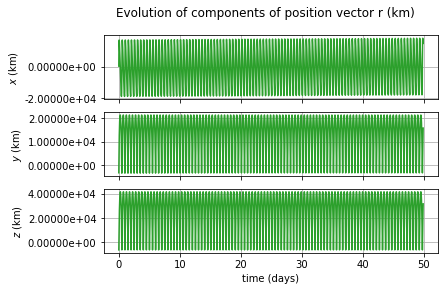

In [38]:
df_pos = pd.DataFrame(r, columns=["x", "y", "z"])
print(df_pos.head())

    
ax = plt.axes(projection='3d')
ax.plot3D(df_pos["x"], df_pos["y"], df_pos["y"], color = 'k', label = 'orbit')
ax.set_aspect('auto')
plt.show()

fig, (ax1, ax2, ax3) = plt.subplots(3, sharex=True)
fig.suptitle(r'Evolution of components of position vector r (km)')
ax1.plot(t_days, df_pos["x"], 'tab:green')
ax1.set(ylabel=r"$x$ (km)")
ax2.plot(t_days, df_pos["y"], 'tab:green')
ax2.set(ylabel=r"$y$ (km)")
ax3.plot(t_days, df_pos["z"], 'tab:green')
ax3.set(xlabel=r"time (days)", ylabel=r"$z$ (km)")
# Add a grid to subplots
ax1.grid()
ax2.grid()
ax3.grid()
# Reformat the y axis notation
ax1.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.5e'))
ax2.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.5e'))
ax3.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.5e'))
plt.show()

In [69]:
# Save r_norm
np.savetxt('/Users/utente73/Documents/Uni Project/pos_molnyaC_14_r.txt', np.transpose(r_norm))
# Save r_norm
np.savetxt('/Users/utente73/Documents/Uni Project/pos_molnyaC_14_v.txt', np.transpose(v_norm))
# Save time
np.savetxt('/Users/utente73/Documents/Uni Project/pos_molnyaC_14_t.txt', t_days)